<a href="https://colab.research.google.com/github/marionaquinmor/image_explainability/blob/main/model_entrenat_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ESTUDI SOBRE L’APLICACIÓ DE TÈCNIQUES D’EXPLICABILITAT EN ALGORISMES D’INTEL·LIGÈNCIA ARTIFICIAL BASATS EN IMATGE MÈDICA**

# <a id="8">Importació de llibreries i imatges</a> 

In [ ]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/TFG/archive.zip'

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-

# <a id="8">Anàlisi de Dades</a> 

In [ ]:
main_path = "/content/chest_xray"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [ ]:
# creació de dataframe amb les dades de train i test
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [ ]:
#visualització de dades de train
df_train

,class,image
0,Normal,/content/chest_xray/train/NORMAL/NORMAL-6727820-0001.jpeg
1,Normal,/content/chest_xray/train/NORMAL/NORMAL-9589634-0001.jpeg
2,Normal,/content/chest_xray/train/NORMAL/NORMAL-9760915-0001.jpeg
3,Normal,/content/chest_xray/train/NORMAL/NORMAL-6954688-0002.jpeg
4,Normal,/content/chest_xray/train/NORMAL/NORMAL-2699389-0002.jpeg
...,...,...
5227,Pneumonia,/content/chest_xray/train/PNEUMONIA/VIRUS-1335423-0006.jpeg
5228,Pneumonia,/content/chest_xray/train/PNEUMONIA/BACTERIA-4038442-0002.jpeg
5229,Pneumonia,/content/chest_xray/train/PNEUMONIA/VIRUS-7682235-0002.jpeg
5230,Pneumonia,/content/chest_xray/train/PNEUMONIA/BACTERIA-9424776-0002.jpeg


In [ ]:
#nombre de imatges de cada classe a train
df_train.groupby(['class']).count()

,image
class,
Normal,1349
Pneumonia,3883


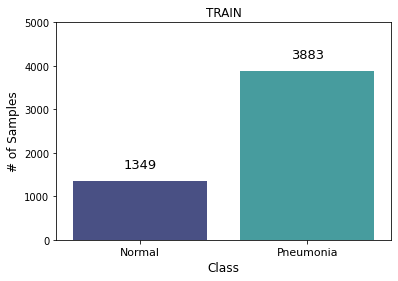

In [ ]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.title("TRAIN")
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

In [ ]:
#visualització de dades de test
df_test

,class,image
0,Normal,/content/chest_xray/test/NORMAL/NORMAL-6703189-0001.jpeg
1,Normal,/content/chest_xray/test/NORMAL/NORMAL-5498455-0001.jpeg
2,Normal,/content/chest_xray/test/NORMAL/NORMAL-4172448-0001.jpeg
3,Normal,/content/chest_xray/test/NORMAL/NORMAL-9799657-0001.jpeg
4,Normal,/content/chest_xray/test/NORMAL/NORMAL-5402107-0001.jpeg
...,...,...
619,Pneumonia,/content/chest_xray/test/PNEUMONIA/BACTERIA-518323-0001.jpeg
620,Pneumonia,/content/chest_xray/test/PNEUMONIA/VIRUS-9564688-0001.jpeg
621,Pneumonia,/content/chest_xray/test/PNEUMONIA/BACTERIA-2131702-0003.jpeg
622,Pneumonia,/content/chest_xray/test/PNEUMONIA/BACTERIA-1768914-0001.jpeg


In [ ]:
#nombre de imatges de cada classe a test
df_test.groupby(['class']).count()

,image
class,
Normal,234
Pneumonia,390


In [ ]:
#ordenació de les imatges de train i test
df_train=df_train.sort_values('image',ignore_index=True)
df_test=df_test.sort_values('image',ignore_index=True)

In [ ]:
df_train

,class,image
0,Normal,/content/chest_xray/train/NORMAL/NORMAL-1003233-0001.jpeg
1,Normal,/content/chest_xray/train/NORMAL/NORMAL-1012843-0001.jpeg
2,Normal,/content/chest_xray/train/NORMAL/NORMAL-1014768-0001.jpeg
3,Normal,/content/chest_xray/train/NORMAL/NORMAL-1023731-0001.jpeg
4,Normal,/content/chest_xray/train/NORMAL/NORMAL-1029510-0001.jpeg
...,...,...
5227,Pneumonia,/content/chest_xray/train/PNEUMONIA/VIRUS-9934736-0003.jpeg
5228,Pneumonia,/content/chest_xray/train/PNEUMONIA/VIRUS-9947411-0002.jpeg
5229,Pneumonia,/content/chest_xray/train/PNEUMONIA/VIRUS-9962961-0002.jpeg
5230,Pneumonia,/content/chest_xray/train/PNEUMONIA/VIRUS-9963654-0001.jpeg


In [ ]:
#creació del conjunt de dades de validació (val)
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [ ]:
#visualització de dades de train després de la ordenació i del split
train_df

,class,image
3566,Pneumonia,/content/chest_xray/train/PNEUMONIA/BACTERIA-8718799-0001.jpeg
2866,Pneumonia,/content/chest_xray/train/PNEUMONIA/BACTERIA-6295192-0003.jpeg
2681,Pneumonia,/content/chest_xray/train/PNEUMONIA/BACTERIA-5615122-0001.jpeg
1199,Normal,/content/chest_xray/train/NORMAL/NORMAL-9031828-0001.jpeg
4619,Pneumonia,/content/chest_xray/train/PNEUMONIA/VIRUS-5822550-0001.jpeg
...,...,...
3476,Pneumonia,/content/chest_xray/train/PNEUMONIA/BACTERIA-8467199-0001.jpeg
678,Normal,/content/chest_xray/train/NORMAL/NORMAL-5634312-0001.jpeg
1560,Pneumonia,/content/chest_xray/train/PNEUMONIA/BACTERIA-1797366-0001.jpeg
2769,Pneumonia,/content/chest_xray/train/PNEUMONIA/BACTERIA-5965088-0001.jpeg


In [ ]:
#nombre de imatges de cada classe de train després del split
train_df.groupby(['class']).count()

,image
class,
Normal,1079
Pneumonia,3106


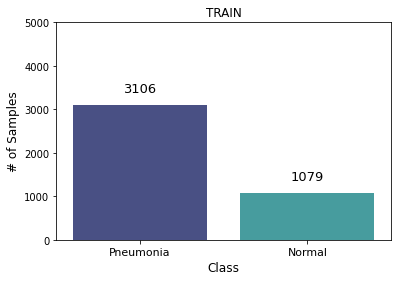

In [ ]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=train_df, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.title("TRAIN")
plt.ylim(0,5000)
plt.xticks([0,1], ['Pneumonia', 'Normal'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

In [ ]:
#visualització de dades de val
val_df

,class,image
2945,Pneumonia,/content/chest_xray/train/PNEUMONIA/BACTERIA-654117-0001.jpeg
4878,Pneumonia,/content/chest_xray/train/PNEUMONIA/VIRUS-7603659-0001.jpeg
3177,Pneumonia,/content/chest_xray/train/PNEUMONIA/BACTERIA-7512869-0002.jpeg
972,Normal,/content/chest_xray/train/NORMAL/NORMAL-7436212-0002.jpeg
3059,Pneumonia,/content/chest_xray/train/PNEUMONIA/BACTERIA-7022864-0004.jpeg
...,...,...
253,Normal,/content/chest_xray/train/NORMAL/NORMAL-2699389-0002.jpeg
4315,Pneumonia,/content/chest_xray/train/PNEUMONIA/VIRUS-3896078-0002.jpeg
687,Normal,/content/chest_xray/train/NORMAL/NORMAL-566227-0001.jpeg
3417,Pneumonia,/content/chest_xray/train/PNEUMONIA/BACTERIA-8313249-0001.jpeg


In [ ]:
#nombre de imatges de cada classe de val després del split
val_df.groupby(['class']).count()

,image
class,
Normal,270
Pneumonia,777


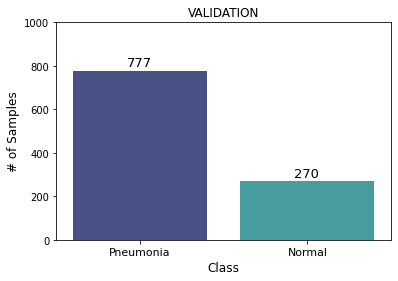

In [ ]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=val_df, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.title("VALIDATION")
plt.ylim(0,1000)
plt.xticks([0,1], ['Pneumonia', 'Normal'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

In [ ]:
#visualització de dades de train després de la ordenació 
df_test

,class,image
0,Normal,/content/chest_xray/test/NORMAL/NORMAL-1049278-0001.jpeg
1,Normal,/content/chest_xray/test/NORMAL/NORMAL-1110860-0001.jpeg
2,Normal,/content/chest_xray/test/NORMAL/NORMAL-11419-0001.jpeg
3,Normal,/content/chest_xray/test/NORMAL/NORMAL-115218-0001.jpeg
4,Normal,/content/chest_xray/test/NORMAL/NORMAL-1160949-0001.jpeg
...,...,...
619,Pneumonia,/content/chest_xray/test/PNEUMONIA/VIRUS-9584831-0001.jpeg
620,Pneumonia,/content/chest_xray/test/PNEUMONIA/VIRUS-9671740-0001.jpeg
621,Pneumonia,/content/chest_xray/test/PNEUMONIA/VIRUS-9783315-0001.jpeg
622,Pneumonia,/content/chest_xray/test/PNEUMONIA/VIRUS-9890836-0001.jpeg


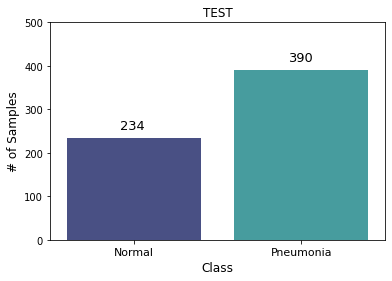

In [ ]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.title("TEST")
plt.ylim(0,500)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

# <a id="8">Balanceig de Dades</a> 

In [ ]:
#nombre total d'imatges de train
TRAIN_IMG_COUNT=train_df['class'].count()
print("Training images count: " + str(TRAIN_IMG_COUNT))

Training images count: 4185


In [ ]:
#nombre d'imatges de train per a cada classe
COUNT_NORMAL = 1079
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = 3106
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1079
Pneumonia images count in training set: 3106


In [ ]:
#càlcul del biaix inicial
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.05730104])

In [ ]:
#càlcul de ponderacions per tal d'equilibrar les classe en l'entrenament
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [ ]:
#llegir les imatges i canviar el format per entrenar correctament 

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'categorical',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'categorical',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'categorical',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


# <a id="8">Entrenament del Model</a> 

In [ ]:
# Define model parameters 
img_width = 224
img_height = 224
epochs = 10

params = {
    'dim': (img_width, img_height),
    'batch_size': 5,
    'n_classes': 2,
    'n_channels': 3,
    'shuffle': True,
}

In [ ]:
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, 
                                             input_shape=(img_width, img_height, 3))

output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(2, activation='softmax')(output)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

random.seed(2024)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128    

In [ ]:
# Set callback functions to early stop training and save the best model so far
#1h
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=2, min_delta=1e-3),
    tf.keras.callbacks.ModelCheckpoint(filepath='./model.h5', monitor='val_loss', 
                                       save_best_only=True, verbose=2)
]

history = model.fit(
    ds_train,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=ds_val,
    class_weight=class_weight
)

Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.1321 - accuracy: 0.9410
Epoch 1: val_loss improved from inf to 0.12085, saving model to ./model.h5
131/131 [==============================] - 893s 7s/step - loss: 0.1321 - accuracy: 0.9410 - val_loss: 0.1208 - val_accuracy: 0.9456
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9773
Epoch 2: val_loss improved from 0.12085 to 0.06218, saving model to ./model.h5
131/131 [==============================] - 894s 7s/step - loss: 0.0586 - accuracy: 0.9773 - val_loss: 0.0622 - val_accuracy: 0.9752
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9835
Epoch 3: val_loss did not improve from 0.06218
131/131 [==============================] - 910s 7s/step - loss: 0.0457 - accuracy: 0.9835 - val_loss: 0.0858 - val_accuracy: 0.9685
Epoch 4/10
131/131 [==============================] - ETA: 0s - loss: 0.0278 - accuracy: 0.9904
Epoch 4: val_loss i

In [ ]:
# Guardar el Modelo
model.save('model_MobileNet_balanced.h5')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/TFG/model_MobileNet_balanced.h5')

In [ ]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.036750923842191696
Val accuracy: 0.9894937872886658


In [ ]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14105497300624847
Test accuracy: 0.9375


# <a id="8">Mètriques d'avaluació</a> 

In [ ]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [ ]:
ds_test.reset()
predictions = model.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions[: , 1]>0.5, 1, 0)

In [ ]:
predictions[220:240]

array([[9.8516220e-01, 1.4837782e-02],
       [6.2409896e-01, 3.7590101e-01],
       [8.7761241e-01, 1.2238759e-01],
       [2.2385752e-01, 7.7614254e-01],
       [9.2803645e-01, 7.1963571e-02],
       [9.9822432e-01, 1.7756814e-03],
       [9.9984968e-01, 1.5028454e-04],
       [9.9688452e-01, 3.1154319e-03],
       [7.3432249e-01, 2.6567754e-01],
       [9.9749005e-01, 2.5099134e-03],
       [9.3571496e-01, 6.4285040e-02],
       [9.8263657e-01, 1.7363431e-02],
       [4.0834752e-01, 5.9165251e-01],
       [9.9672359e-01, 3.2763863e-03],
       [1.0131691e-05, 9.9998987e-01],
       [6.4098494e-06, 9.9999356e-01],
       [2.5087979e-06, 9.9999750e-01],
       [9.5579080e-06, 9.9999046e-01],
       [5.5665822e-07, 9.9999940e-01],
       [7.7256855e-06, 9.9999225e-01]], dtype=float32)

In [ ]:
pred_labels[220:240]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1])

In [ ]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9375


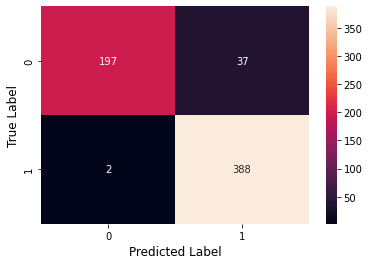

In [ ]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [ ]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91       234
           1       0.91      0.99      0.95       390

    accuracy                           0.94       624
   macro avg       0.95      0.92      0.93       624
weighted avg       0.94      0.94      0.94       624



ROC_AUC:  0.9968003506465044


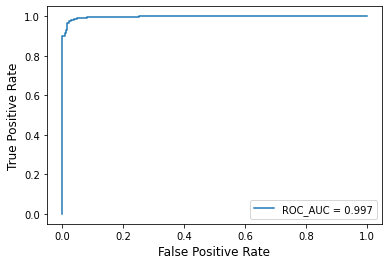

In [ ]:
roc_auc = metrics.roc_auc_score(Y_test, predictions[: , 1])
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions[: , 1])

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

In [ ]:
y_prob = model.predict(ds_test)
y_prob[:20]

array([[5.4955357e-01, 4.5044640e-01],
       [9.9812549e-01, 1.8745245e-03],
       [9.7115064e-01, 2.8849384e-02],
       [7.9313028e-01, 2.0686977e-01],
       [9.9707508e-01, 2.9248691e-03],
       [9.9176943e-01, 8.2305372e-03],
       [9.9369591e-01, 6.3040508e-03],
       [5.0997329e-01, 4.9002668e-01],
       [9.9970335e-01, 2.9663453e-04],
       [9.9309510e-01, 6.9049071e-03],
       [9.9977368e-01, 2.2636834e-04],
       [9.2198390e-01, 7.8016102e-02],
       [8.6152208e-01, 1.3847783e-01],
       [4.9380821e-01, 5.0619185e-01],
       [5.5670333e-01, 4.4329664e-01],
       [3.3456916e-01, 6.6543090e-01],
       [7.3001486e-01, 2.6998514e-01],
       [9.7660387e-01, 2.3396127e-02],
       [7.9449147e-01, 2.0550849e-01],
       [9.9133790e-01, 8.6621353e-03]], dtype=float32)